# Task 1: EDA

In [36]:
import pycaret
pycaret.__version__

'3.3.2'

In [37]:
# Libraries for EDA
import pandas as pd
from pycaret.regression import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import seaborn as sns
import mlflow


In [38]:
mlflow.__version__

'2.8.0'

In [39]:
# Loading the dataset
file_path = r"C:\Users\jysh2\OneDrive\Documents\code\mlops\Datasets\02_Used_Car_Prices.xlsx"
df = pd.read_excel(file_path)

# Preview of the dataset
From the preview of the dataset below we can see that columns such as Mileage, Engine and Power containt letters such as km/kg and 998 CC. While it makes it easy for us humans to understand the information of the dataset, the setup function from pycaret requires the dataset to be in the right dataset format first before we can use the function to ensure it runs properly. Otherwise when you perform imputation methods on missing values such as the columns above, it will identify it as a string and it won't do anything to it.

In [40]:
# Preview the dataset
df.head()

,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price (INR Lakhs)
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,175000.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,1250000.0
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,450000.0
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,600000.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,1774000.0


In [41]:
# Preview of the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand_Model        6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  Price (INR Lakhs)  6019 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 564.4+ KB


The Mileage column contains km per kg and km per liter. 


In [42]:
# Looking over the data types of mileage to see what other unique values are in there to see if there is a need to be in integer or float values
df["Fuel_Type"].unique()

array(['CNG', 'Diesel', 'Petrol', 'LPG', 'Electric'], dtype=object)

In [43]:
# only fuel_type of "electric" has null values on their mileage and there are only 2 entries for electric fuel type cars, hence it will be best to remove them since there is an insignificant amount of it to be used
df[df["Mileage"].isnull()]

,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price (INR Lakhs)
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72 CC,41 bhp,5.0,1300000.0
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798 CC,73 bhp,5.0,1275000.0


In [44]:
df[df["Fuel_Type"] == "Electric"]

,Brand_Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price (INR Lakhs)
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72 CC,41 bhp,5.0,1300000.0
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798 CC,73 bhp,5.0,1275000.0


In [45]:
# There are missing values within the given dataset
df.isnull().sum()

Brand_Model           0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price (INR Lakhs)     0
dtype: int64

# Things to do before we use the setup function in PyCaret
1. Address the values in Mileage to ensure that it follows only one metric instead of 2
2. Split the string and the numerical values apart, so that we can utilise imputation to ensure the numerical values are placed adequately, otherwise it will not impute missing data when the column data type is string
3. Split the Brand_Model to Brand and Model separately as it may be a driving force to increase or decrease the price of a car.

The conversion of km/kg to kmpl is based off the links below:
- https://www.geeksforgeeks.org/lpg-gas-14-2-kg-equals-how-many-liters/
- https://www.elgas.com.au/elgas-knowledge-hub/residential-lpg/lpg-gas-unit-conversions/

The approximate density of CNG is 0.714 kg per cubic meter. 1 kg of CNG = 1/0.714 would be at 1.4 liters
The approximate density of LPG is 0.51 kg per liter. 1 kg of LPG = 1/0.51 would be at 1.96 liters



In [46]:
df["Mileage_Value"] = df["Mileage"].str.extract("(\d+\.\d+)").astype(float)
df["Mileage_Unit"] = df["Mileage"].str.extract("([a-zA-Z]+)$")  # Extract unit

# Convert km/kg to kmpl
df["Mileage (kmpl)"] = df.apply(lambda row: row["Mileage_Value"] * 1.4 if row["Fuel_Type"] == "CNG"
                              else (row["Mileage_Value"] * 1.96 if row["Fuel_Type"] == "LPG"
                              else row["Mileage_Value"]), axis=1)

# Drop old Mileage column
df.drop(columns=["Mileage", "Mileage_Value", "Mileage_Unit"], inplace=True)

In [47]:
# Splitting 'Brand_Model' into 'Brand' and 'Model'
df[['Brand', 'Model']] = df['Brand_Model'].str.split(' ', 1, expand=True)

# Drop the old 'Brand_Model' column
df.drop(columns=['Brand_Model'], inplace=True)

In [48]:
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price (INR Lakhs),Mileage (kmpl),Brand,Model
0,Mumbai,2010,72000,CNG,Manual,First,998 CC,58.16 bhp,5.0,175000.0,37.24,Maruti,Wagon R LXI CNG
1,Pune,2015,41000,Diesel,Manual,First,1582 CC,126.2 bhp,5.0,1250000.0,19.67,Hyundai,Creta 1.6 CRDi SX Option
2,Chennai,2011,46000,Petrol,Manual,First,1199 CC,88.7 bhp,5.0,450000.0,18.20,Honda,Jazz V
3,Chennai,2012,87000,Diesel,Manual,First,1248 CC,88.76 bhp,7.0,600000.0,20.77,Maruti,Ertiga VDI
4,Coimbatore,2013,40670,Diesel,Automatic,Second,1968 CC,140.8 bhp,5.0,1774000.0,15.20,Audi,A4 New 2.0 TDI Multitronic


Now that the mileage values has been streamlined to contain just kmpl, next is to address the values in Engine and Power column as they are recognised as string rather than integer values because of the metric listed beside the numerical values.

In [49]:
# Extract numerical values from Engine (removes 'CC')
df["Engine (CC)"] = df["Engine"].str.extract("(\d+)").astype(float)

# Extract numerical values from Power (removes 'bhp')
df["Power (bhp)"] = df["Power"].str.extract("(\d+\.\d+|\d+)").astype(float)

# Drop old columns
df.drop(columns=["Engine", "Power"], inplace=True)

In [50]:
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price (INR Lakhs),Mileage (kmpl),Brand,Model,Engine (CC),Power (bhp)
0,Mumbai,2010,72000,CNG,Manual,First,5.0,175000.0,37.24,Maruti,Wagon R LXI CNG,998.0,58.16
1,Pune,2015,41000,Diesel,Manual,First,5.0,1250000.0,19.67,Hyundai,Creta 1.6 CRDi SX Option,1582.0,126.20
2,Chennai,2011,46000,Petrol,Manual,First,5.0,450000.0,18.20,Honda,Jazz V,1199.0,88.70
3,Chennai,2012,87000,Diesel,Manual,First,7.0,600000.0,20.77,Maruti,Ertiga VDI,1248.0,88.76
4,Coimbatore,2013,40670,Diesel,Automatic,Second,5.0,1774000.0,15.20,Audi,A4 New 2.0 TDI Multitronic,1968.0,140.80


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6019 non-null   object 
 1   Year               6019 non-null   int64  
 2   Kilometers_Driven  6019 non-null   int64  
 3   Fuel_Type          6019 non-null   object 
 4   Transmission       6019 non-null   object 
 5   Owner_Type         6019 non-null   object 
 6   Seats              5977 non-null   float64
 7   Price (INR Lakhs)  6019 non-null   float64
 8   Mileage (kmpl)     6017 non-null   float64
 9   Brand              6019 non-null   object 
 10  Model              6019 non-null   object 
 11  Engine (CC)        5983 non-null   float64
 12  Power (bhp)        5876 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 611.4+ KB


# EDA
Now that we know that there are some small amount of missing values in the dataset, next is to look at the distribution of the dataset

In [52]:
# Summary of numerical columns
df.describe()

,Year,Kilometers_Driven,Seats,Price (INR Lakhs),Mileage (kmpl),Engine (CC),Power (bhp)
count,6019.000000,6.019000e+03,5977.000000,6.019000e+03,6017.000000,5983.000000,5876.000000
mean,2013.358199,5.873838e+04,5.278735,9.479468e+05,18.260515,1621.276450,113.253050
std,3.269742,9.126884e+04,0.808840,1.118792e+06,4.940417,601.355233,53.874957
min,1998.000000,1.710000e+02,0.000000,4.400000e+04,0.000000,72.000000,34.200000
25%,2011.000000,3.400000e+04,5.000000,3.500000e+05,15.260000,1198.000000,75.000000
50%,2014.000000,5.300000e+04,5.000000,5.640000e+05,18.190000,1493.000000,97.700000
75%,2016.000000,7.300000e+04,5.000000,9.950000e+05,21.100000,1984.000000,138.100000
max,2019.000000,6.500000e+06,10.000000,1.600000e+07,51.352000,5998.000000,560.000000


In [53]:
# Summary of categorical columns
df.describe(include=['object'])

,Location,Fuel_Type,Transmission,Owner_Type,Brand,Model
count,6019,6019,6019,6019,6019,6019
unique,11,5,2,4,31,1876
top,Mumbai,Diesel,Manual,First,Maruti,XUV500 W8 2WD
freq,790,3205,4299,4929,1211,49


Distribution of the used cars are right-skewed, majority of the car prices are concentrated in the lower price ranges.
What this means is that we need to do the following:
1. normalize the values to improve regression model performance.
2. handle outliers to reduce negative impact on model training phase
3. numeric feature scaling to improve model convergence and prevent large-value biases.

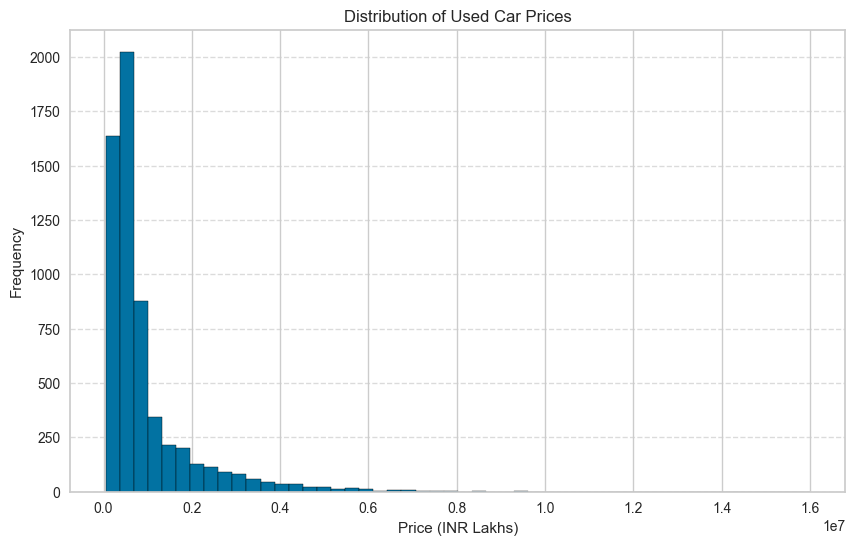

In [54]:
# Distribution of Car Prices
plt.figure(figsize=(10, 6))
plt.hist(df["Price (INR Lakhs)"].dropna(), bins=50, edgecolor='black')
plt.xlabel("Price (INR Lakhs)")
plt.ylabel("Frequency")
plt.title("Distribution of Used Car Prices")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The dataset is dominated by diesel and petrol cars while CNG, LPG and electric are underrepresented. This imbalance can cause the model to be biased towards diesel and petrol, so there is a need to apply target encoding or one-hot encoding to prevent minority classes from being ignored. There will also be a need to group the low-frequency categories into "Other" category.

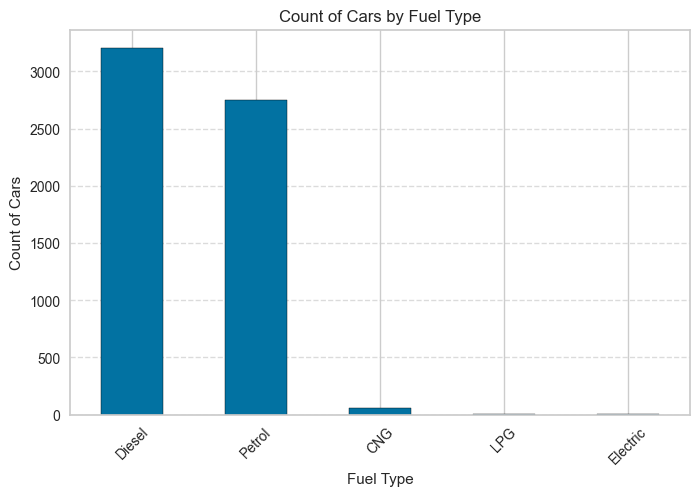

In [55]:
# Car Count by Fuel Type
plt.figure(figsize=(8, 5))
df["Fuel_Type"].value_counts().plot(kind="bar", edgecolor='black')
plt.xlabel("Fuel Type")
plt.ylabel("Count of Cars")
plt.title("Count of Cars by Fuel Type")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Data imbalance in transmission type is big, and may lead to model predicting manual cars more accurately but struggle with automatic cars, would consider using SMOTE to balance the dataset.

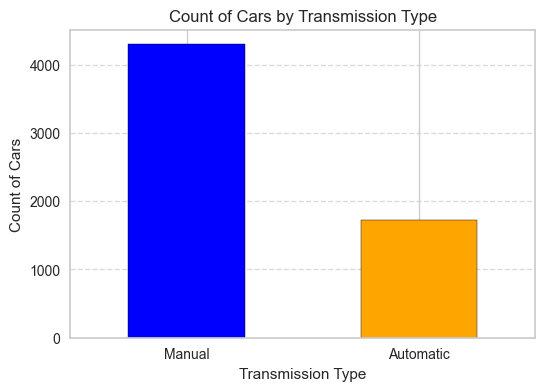

In [56]:
# Car Count by Transmission Type
plt.figure(figsize=(6, 4))
df["Transmission"].value_counts().plot(kind="bar", edgecolor='black', color=['blue', 'orange'])
plt.xlabel("Transmission Type")
plt.ylabel("Count of Cars")
plt.title("Count of Cars by Transmission Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The dataset is dominated by First-Owner cars, while Second, Third, and Fourth & Above owners are significantly fewer. This imbalance could cause the model to be biased toward first-owner cars, making it less effective at predicting prices for multiple-owner vehicles.

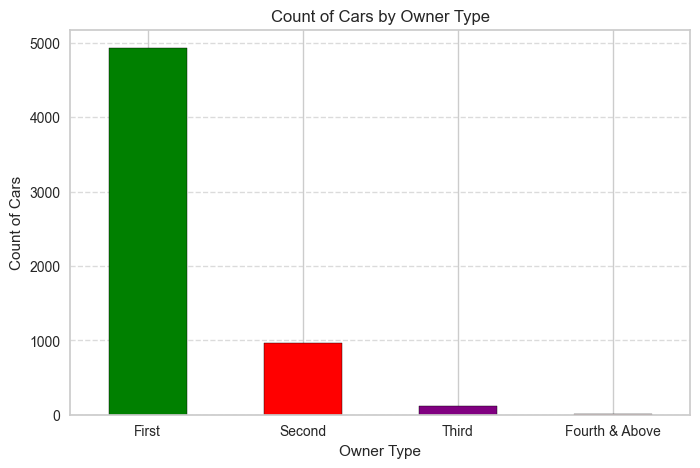

In [57]:
# Car Count by Owner Type
plt.figure(figsize=(8, 5))
df["Owner_Type"].value_counts().plot(kind="bar", edgecolor='black', color=['green', 'red', 'purple', 'brown'])
plt.xlabel("Owner Type")
plt.ylabel("Count of Cars")
plt.title("Count of Cars by Owner Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The bar shows the top 10 car brands with the highest average used car prices, indicating premium brands compared to budget-friendly ones. Some brands (e.g., Lamborghini, Bentley, Porsche) have extremely high prices, while others (Mini, Isuzu) are significantly lower.
This large price variation may introduce outliers that affect model accuracy.

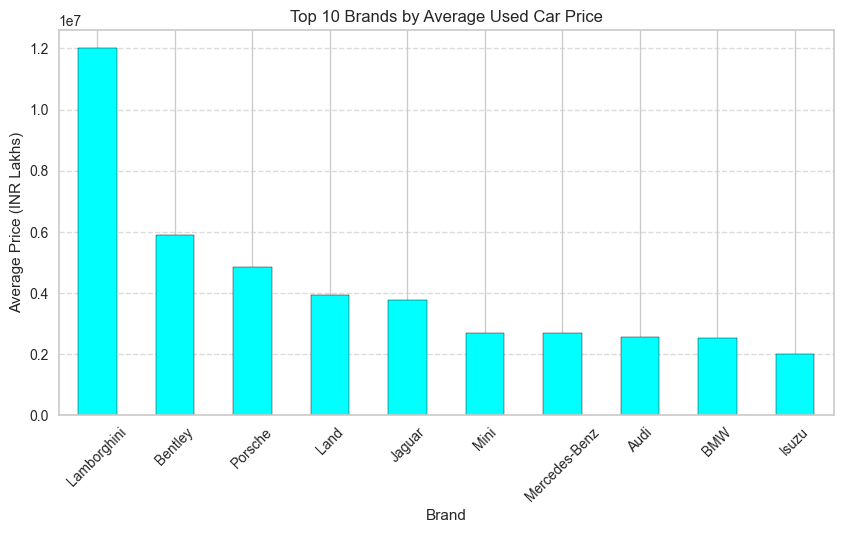

In [58]:
# Average Price by Brand/Model (Top 10)
brand_avg_price = df.groupby("Brand")["Price (INR Lakhs)"].mean().sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 5))
brand_avg_price.plot(kind="bar", edgecolor='black', color='cyan')
plt.xlabel("Brand")
plt.ylabel("Average Price (INR Lakhs)")
plt.title("Top 10 Brands by Average Used Car Price")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The newer the car (higher year), the higher its price.Older cars tend to have lower prices, which aligns with depreciation trends. May consider a feature that represents the car age to better capture the depreciation effect.

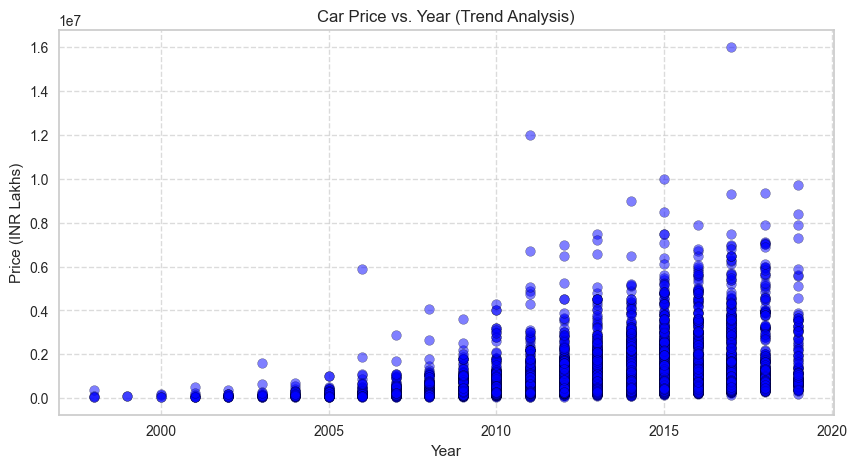

In [59]:
# Car Price vs. Year (Trend Analysis)
plt.figure(figsize=(10, 5))
plt.scatter(df["Year"], df["Price (INR Lakhs)"], alpha=0.5, color='blue', edgecolors='black')
plt.xlabel("Year")
plt.ylabel("Price (INR Lakhs)")
plt.title("Car Price vs. Year (Trend Analysis)")
plt.grid(linestyle='--', alpha=0.7)
plt.show()


Most cars cluster at lower kilometers driven, with higher prices for cars that have driven less. Cars with very high kilometers (above 200,000 km) show a significant drop in price.

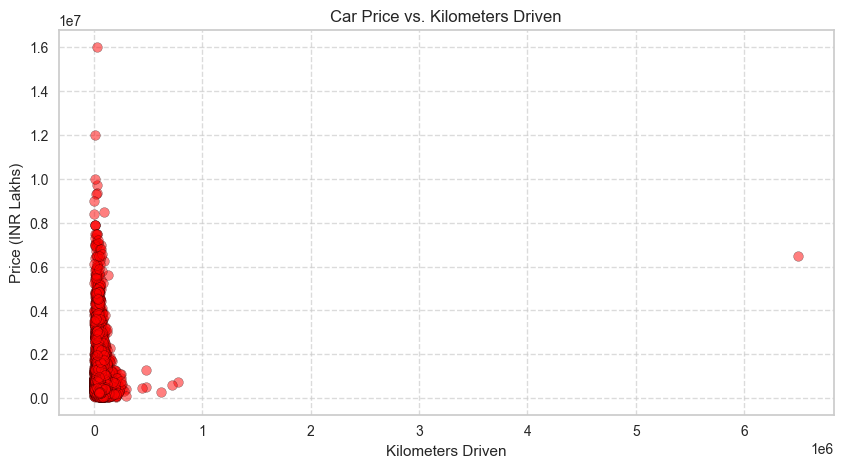

In [60]:
# Car Price vs. Kilometers Driven (Impact of Usage on Price)
plt.figure(figsize=(10, 5))
plt.scatter(df["Kilometers_Driven"], df["Price (INR Lakhs)"], alpha=0.5, color='red', edgecolors='black')
plt.xlabel("Kilometers Driven")
plt.ylabel("Price (INR Lakhs)")
plt.title("Car Price vs. Kilometers Driven")
plt.grid(linestyle='--', alpha=0.7)
plt.show()


Diesel and Electric vehicles have significantly higher average prices. LPG and CNG cars tend to have the lowest average prices. Petrol cars are priced in the middle.

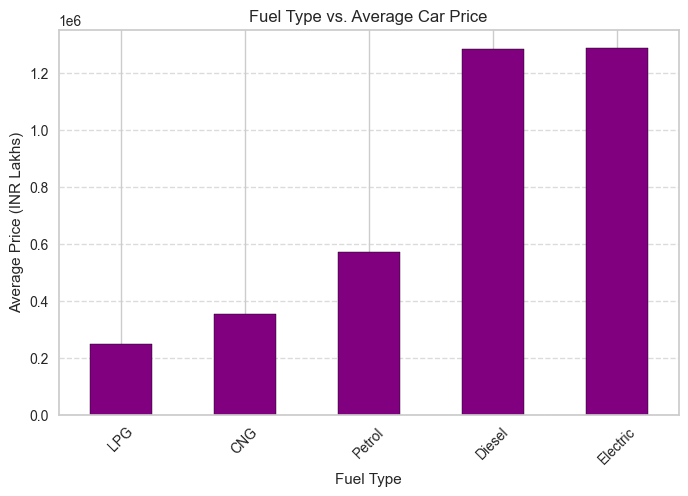

In [61]:
# Fuel Type vs. Average Car Price
fuel_avg_price = df.groupby("Fuel_Type")["Price (INR Lakhs)"].mean().sort_values()

# Plotting
plt.figure(figsize=(8, 5))
fuel_avg_price.plot(kind="bar", edgecolor='black', color='purple')
plt.xlabel("Fuel Type")
plt.ylabel("Average Price (INR Lakhs)")
plt.title("Fuel Type vs. Average Car Price")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Automatic cars have much higher average prices than manual cars. Manual cars are generally more affordable, as they are found in budget-friendly models.

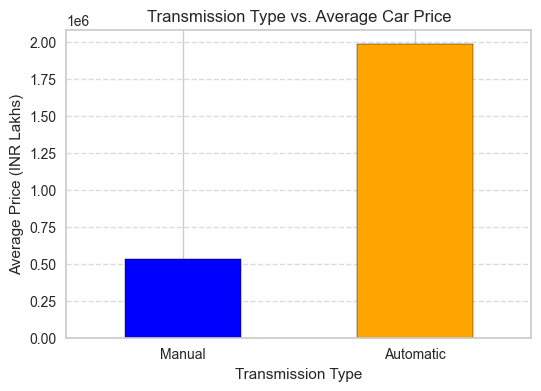

In [62]:
# Transmission Type vs. Average Car Price
transmission_avg_price = df.groupby("Transmission")["Price (INR Lakhs)"].mean().sort_values()

# Plotting
plt.figure(figsize=(6, 4))
transmission_avg_price.plot(kind="bar", edgecolor='black', color=['blue', 'orange'])
plt.xlabel("Transmission Type")
plt.ylabel("Average Price (INR Lakhs)")
plt.title("Transmission Type vs. Average Car Price")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


First-owner cars have the highest resale values because they are newer and have less wear & tear. Prices drop significantly for second, third, and fourth-owner vehicles due to depreciation and potential maintenance issues.

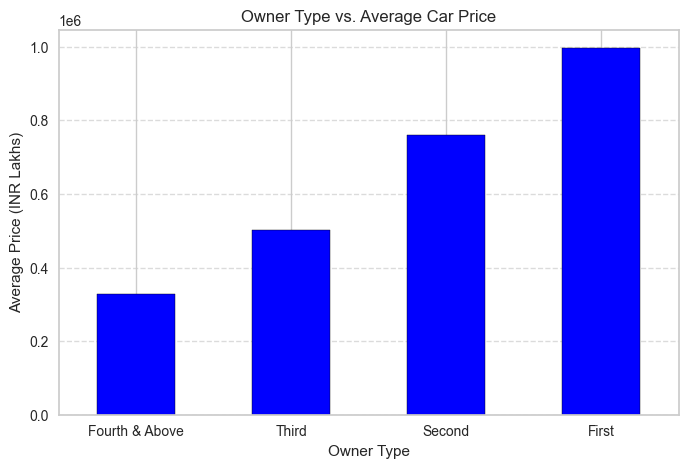

In [63]:
# Owner Type vs. Average Car Price
owner_avg_price = df.groupby("Owner_Type")["Price (INR Lakhs)"].mean().sort_values()

# Plotting
plt.figure(figsize=(8, 5))
owner_avg_price.plot(kind="bar", edgecolor='black', color=['blue'])
plt.xlabel("Owner Type")
plt.ylabel("Average Price (INR Lakhs)")
plt.title("Owner Type vs. Average Car Price")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


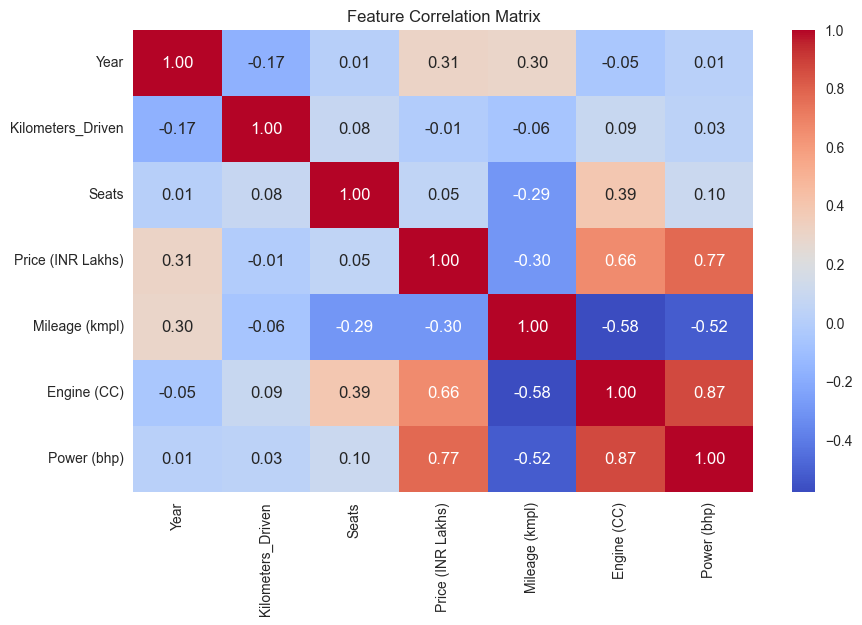

In [64]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=["number"])

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Plot the heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Data Preparation
Based on the visualisation that I had done below are the list of tasks to be done
- Handle skewed price distribution
- Remove outliers
- Convert categorical variables using encoding
- Ensure stratify train-test split
- Remove missing values
- Feature engineering
- Enable feature interaction
- Group rare categories to avoid sparse data issues
- Normalize numerical features
- Use polynomial features for non-linear relationships

In [65]:
# cols_to_log = ["Price (INR Lakhs)", "Kilometers_Driven", "Engine (CC)", "Power (bhp)"]
# df[cols_to_log] = df[cols_to_log].apply(lambda x: np.log1p(x))  # log(1+x) to handle zeros

In [66]:
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price (INR Lakhs),Mileage (kmpl),Brand,Model,Engine (CC),Power (bhp)
0,Mumbai,2010,72000,CNG,Manual,First,5.0,175000.0,37.24,Maruti,Wagon R LXI CNG,998.0,58.16
1,Pune,2015,41000,Diesel,Manual,First,5.0,1250000.0,19.67,Hyundai,Creta 1.6 CRDi SX Option,1582.0,126.20
2,Chennai,2011,46000,Petrol,Manual,First,5.0,450000.0,18.20,Honda,Jazz V,1199.0,88.70
3,Chennai,2012,87000,Diesel,Manual,First,7.0,600000.0,20.77,Maruti,Ertiga VDI,1248.0,88.76
4,Coimbatore,2013,40670,Diesel,Automatic,Second,5.0,1774000.0,15.20,Audi,A4 New 2.0 TDI Multitronic,1968.0,140.80


In [67]:
cols_to_log = ["Price (INR Lakhs)", "Kilometers_Driven", "Engine (CC)", "Power (bhp)"]
df[cols_to_log] = df[cols_to_log].apply(lambda x: np.log1p(x))  # log(1+x) to handle zeros

In [68]:
# pycaret setup
reg = setup(df, target="Price (INR Lakhs)", numeric_imputation="median", remove_outliers=True, normalize=True, # transformation=True, transformation_method="quantile", transform_target=True, transform_target_method='quantile'
            bin_numeric_features=['Year', 'Mileage (kmpl)', 'Engine (CC)', 'Power (bhp)'], remove_multicollinearity=True, multicollinearity_threshold=0.85,
            log_experiment=True, experiment_name="car_price_exp", session_id=123, n_jobs=6)

,Description,Value
0,Session id,123
1,Target,Price (INR Lakhs)
2,Target type,Regression
3,Original data shape,"(6019, 13)"
4,Transformed data shape,"(5808, 29)"
5,Transformed train set shape,"(4002, 29)"
6,Transformed test set shape,"(1806, 29)"
7,Numeric features,6
8,Categorical features,6
9,Rows with missing values,2.4%


In [69]:
get_config("X_train_transformed").isnull().sum()

Location_Coimbatore          0
Location_Chennai             0
Location_Delhi               0
Location_Kochi               0
Location_Pune                0
Location_Hyderabad           0
Location_Bangalore           0
Location_Ahmedabad           0
Location_Mumbai              0
Location_Kolkata             0
Location_Jaipur              0
Year                         0
Kilometers_Driven            0
Fuel_Type_Diesel             0
Fuel_Type_Petrol             0
Fuel_Type_CNG                0
Fuel_Type_LPG                0
Fuel_Type_Electric           0
Transmission                 0
Owner_Type_First             0
Owner_Type_Third             0
Owner_Type_Second            0
Owner_Type_Fourth & Above    0
Seats                        0
Mileage (kmpl)               0
Brand                        0
Model                        0
Power (bhp)                  0
dtype: int64

# Training models to fine the best model

In [70]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.2292,0.1024,0.3195,0.8633,0.0223,0.0172,0.0480
ridge,Ridge Regression,0.2293,0.1025,0.3197,0.8632,0.0223,0.0173,0.0510
lr,Linear Regression,0.2295,0.1026,0.3199,0.8630,0.0223,0.0173,0.2570
huber,Huber Regressor,0.2300,0.1039,0.3217,0.8615,0.0224,0.0173,0.0510
knn,K Neighbors Regressor,0.2623,0.1389,0.3723,0.8144,0.0260,0.0197,0.0490
par,Passive Aggressive Regressor,0.2887,0.1516,0.3873,0.7981,0.0271,0.0217,0.0480
et,Extra Trees Regressor,0.2493,0.1600,0.3989,0.7877,0.0278,0.0188,0.1300
gbr,Gradient Boosting Regressor,0.2686,0.1814,0.4245,0.7593,0.0295,0.0202,0.1020
lightgbm,Light Gradient Boosting Machine,0.2593,0.1859,0.4298,0.7535,0.0299,0.0195,0.0760
rf,Random Forest Regressor,0.2724,0.2029,0.4494,0.7303,0.0313,0.0205,0.1460


# Tuning the best model

In [71]:
# train model
best = create_model('br')

# tune model
tuned_best = tune_model(best, optimize = 'RMSE', choose_better=True, fold=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2292,0.0969,0.3113,0.8767,0.0219,0.0173
1,0.2457,0.1276,0.3572,0.8432,0.0242,0.0181
2,0.2267,0.0995,0.3154,0.8686,0.0224,0.0172
3,0.2177,0.0920,0.3033,0.8607,0.0213,0.0165
4,0.2324,0.1039,0.3224,0.8569,0.0229,0.0177
5,0.2337,0.0996,0.3155,0.8685,0.0222,0.0176
6,0.2350,0.1183,0.3439,0.8660,0.0234,0.0175
7,0.2206,0.0881,0.2967,0.8870,0.0207,0.0166
8,0.2270,0.0984,0.3136,0.8415,0.0221,0.0172


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2184,0.0891,0.2986,0.8908,0.0208,0.0164
1,0.2413,0.1026,0.3203,0.8643,0.0228,0.0183
2,0.2375,0.1249,0.3534,0.8506,0.0238,0.0174
3,0.2364,0.1065,0.3263,0.8649,0.0225,0.0176
4,0.2216,0.0903,0.3005,0.8873,0.0209,0.0166
5,0.2316,0.1057,0.3252,0.8501,0.0234,0.0177
6,0.2108,0.0757,0.2751,0.8782,0.0193,0.0159
7,0.2242,0.1070,0.3271,0.8520,0.0230,0.0170
8,0.2291,0.0941,0.3067,0.8614,0.0216,0.0174


Fitting 20 folds for each of 10 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


# Model to use
- Huber Regressor

In [72]:
# default model
print(best)

# tuned model
print(tuned_best)

BayesianRidge()
BayesianRidge()


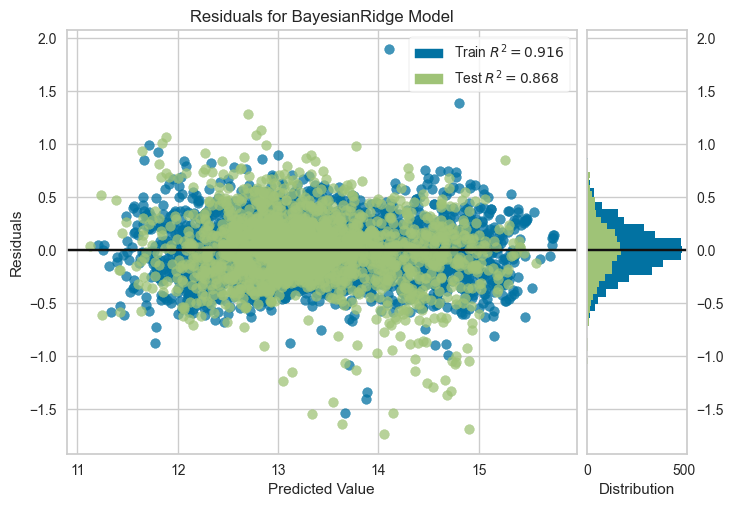

In [73]:
# plot residuals
plot_model(tuned_best, plot = 'residuals')

In [74]:
evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [75]:
# predict on test set
holdout_pred = predict_model(tuned_best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.2331,0.1036,0.3218,0.8683,0.0223,0.0175


In [76]:
# show predictions df
holdout_pred.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Mileage (kmpl),Brand,Model,Engine (CC),Power (bhp),Price (INR Lakhs),prediction_label
5621,Pune,2012,11.736077,Diesel,Automatic,First,7.0,11.5,Toyota,Fortuner 4x2 4 Speed AT,8.000685,5.135798,14.115616,14.042429
6014,Delhi,2014,10.217056,Diesel,Manual,First,5.0,28.4,Maruti,Swift VDI,7.130098,4.317488,13.071073,12.705976
3498,Jaipur,2012,11.289794,Diesel,Manual,First,5.0,22.9,Maruti,Swift VDI,7.130098,4.317488,12.959846,12.626874
1963,Pune,2017,10.463132,Diesel,Automatic,First,5.0,17.9,Mercedes-Benz,GLA Class 200 d Sport,7.670429,4.919981,14.669927,14.547215
4511,Chennai,2009,11.002116,Diesel,Manual,First,5.0,15.0,Volkswagen,Jetta 2007-2011 1.9 TDI Trendline,7.548029,4.663439,12.899222,13.080612


In [77]:
# finalize the model
final_best = finalize_model(tuned_best)

In [78]:
save_model(tuned_best, model_name = 'used_car_sales_pipeline_test')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Year', 'Kilometers_Driven',
                                              'Seats', 'Mileage (kmpl)',
                                              'Engine (CC)', 'Power (bhp)'],
                                     transformer=SimpleImputer(strategy='median'))),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Location', 'Fuel_Type',
                                              'Transmission', 'Owner_Type',
                                              'Brand', 'Model'],
                                     transformer=...
                                              'Engine (CC)', 'Power (bhp)'],
                                     transformer=KBinsDiscretizer(encode='ordinal',
                                                                  strategy='kmeans'))),
                 ('remove_outliers',
                  T

In [82]:
get_config("X_test_transformed")

,Location_Coimbatore,Location_Chennai,Location_Delhi,Location_Kochi,Location_Pune,Location_Hyderabad,Location_Bangalore,Location_Ahmedabad,Location_Mumbai,Location_Kolkata,...,Transmission,Owner_Type_First,Owner_Type_Third,Owner_Type_Second,Owner_Type_Fourth & Above,Seats,Mileage (kmpl),Brand,Model,Power (bhp)
5621,-0.347863,-0.275330,-0.316792,-0.355934,3.056319,-0.383878,-0.250895,-0.190396,-0.392826,-0.316315,...,-1.652189,0.412938,-0.080866,-0.40168,-0.015809,2.257512,-1.593542,0.726104,0.985022,1.450980
6014,-0.347863,-0.275330,3.156641,-0.355934,-0.327191,-0.383878,-0.250895,-0.190396,-0.392826,-0.316315,...,0.605257,0.412938,-0.080866,-0.40168,-0.015809,-0.360822,1.210307,-0.708765,-1.062636,-0.686632
3498,-0.347863,-0.275330,-0.316792,-0.355934,-0.327191,-0.383878,-0.250895,-0.190396,-0.392826,-0.316315,...,0.605257,0.412938,-0.080866,-0.40168,-0.015809,-0.360822,1.210307,-0.708765,-1.062636,-0.686632
1963,-0.347863,-0.275330,-0.316792,-0.355934,3.056319,-0.383878,-0.250895,-0.190396,-0.392826,-0.316315,...,-1.652189,0.412938,-0.080866,-0.40168,-0.015809,-0.360822,-0.191617,2.252281,1.266263,0.382174
4511,-0.347863,3.632009,-0.316792,-0.355934,-0.327191,-0.383878,-0.250895,-0.190396,-0.392826,-0.316315,...,0.605257,0.412938,-0.080866,-0.40168,-0.015809,-0.360822,-0.191617,-0.387460,0.065142,0.382174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3520,-0.347863,-0.275330,3.156641,-0.355934,-0.327191,-0.383878,-0.250895,-0.190396,-0.392826,-0.316315,...,-1.652189,0.412938,-0.080866,-0.40168,-0.015809,-0.360822,-0.191617,2.138909,0.934584,-0.686632
5114,-0.347863,-0.275330,-0.316792,-0.355934,-0.327191,-0.383878,-0.250895,-0.190396,2.545658,-0.316315,...,0.605257,0.412938,-0.080866,-0.40168,-0.015809,-0.360822,-0.191617,-0.673938,-0.646413,-0.686632
2690,-0.347863,-0.275330,-0.316792,-0.355934,-0.327191,-0.383878,3.985734,-0.190396,-0.392826,-0.316315,...,-1.652189,0.412938,-0.080866,-0.40168,-0.015809,-0.360822,-1.593542,2.247439,1.612312,2.519786
902,-0.347863,-0.275330,-0.316792,-0.355934,-0.327191,2.604994,-0.250895,-0.190396,-0.392826,-0.316315,...,-1.652189,0.412938,-0.080866,-0.40168,-0.015809,-0.360822,-0.191617,2.247439,1.174336,1.450980
